# Ensemble de Mandelbrot et Deep Zoom image

Calcul d'une pyramide d'images, pour créer une vue interactive zoomable de l'ensemble fractal de Mandelbrot.

**L'ensemble de Mandelbrot** est une des figures fractals la plus célèbre ([wikipedia](https://en.wikipedia.org/wiki/Mandelbrot_set)). Il est fascinant de plonger à l'intérieure de l'image en continuant de zoomer et de découvrir les mêmes motifs apparaîtres, imbriqués à l'intérieure de structures complexes.

La formulation mathématique de l'ensemble est, à l'inverse, étrangement simple. La couleur du pixel $(x, y)$ est déterminée suivant la convergence de la suite mathématique suivante (quadratique, et en nombre complexe):

$$
z_{n+1} = z_n^2 + c 
$$
$$
z_0 = 0
$$
$$ c = x+iy $$

** Deep Zoom Image : ** Il est courant de voir des images interactives ayant des multiples niveaux de zoom. L'exemple bien sûr est _Google Earth_, ou par exemple ce [panorama du Mont Blanc](http://www.in2white.com/). Je voulais depuis longtemps essayer cela avec une image générée informatiquement. L'ensemble de Mandelbrot s'y prete très bien.

On trouve [ici](https://msdn.microsoft.com/fr-fr/library/cc645077) la description du format d'image _Deep Zoom Image_ (DZI). L'image est devellopée en niveau de zoom successifs, doublant à chaque fois la largeur de l'image.

La taille en pixel de l'image au niveau numéro $i$ est $L = 2^i$. Le niveau zéro correspond donc à une image de 1x1 pixel, le niveau 2 à une image de 2x2 pixels... etc... Les premiers niveaux ne sont donc pas utiles. Il faut attendre le 7ième niveau, par exemple, pour avoir une image de 128x128 pixels, et cela va très très vite ensuite.

In [14]:
print(  [ (i, 2**i) for i in range(12) ] )

[(0, 1), (1, 2), (2, 4), (3, 8), (4, 16), (5, 32), (6, 64), (7, 128), (8, 256), (9, 512), (10, 1024), (11, 2048)]


L'image de chaque niveau est decomposée en tuile de taille fixe. L'idée est de charger en mémoire seulement les tuiles en cours de visualisation, et non l'ensemble de l'image.

Les images d'un niveau sont enregistrées dans un dossier nomé suivant le numéro du niveau de zoom. Puis chaque image est nommée suivant le schéma `row_col.png` avec `row` et `col` le numéro de ligne et de colonne de l'image. 

https://openseadragon.github.io/

## Calcul numérique de l'ensemble 

In [2]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import time

_Remarque:_ On evite l'utilisation de structure de donnée avancée (nombres complexes) pour reduire le temps de calcul

In [5]:
def computeTile( X, Y ):
    nMax_iter = 100

    Z = np.zeros( (len(X), len(Y)) )
    for i, x in enumerate( X ):
        for j, y in enumerate( Y ):

            zx, zy = x, y
            for k in range( nMax_iter ):
                if zx*zx + zy*zy < 4:
                    zx_temp = zx*zx - zy*zy + x
                    zy = 2*zx*zy + y
                    zx = zx_temp
                else:
                    break
            else:
                Z[i, j] = 1 #np.abs( z )
    return Z

## Test du calcul

In [6]:
x_min, x_max = -2, 1
y_min, y_max = -1, 1

In [7]:
nx, ny = 64, 64

X = np.linspace( x_min, x_max, nx )
Y = np.linspace( y_min, y_max, ny )

0.189


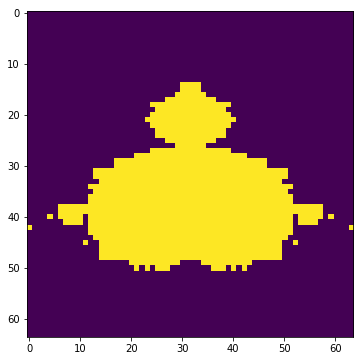

In [8]:
t = time.time()
Z = computeTile( X, Y )
print( "%.3f" % (time.time()-t))
plt.figure(figsize=(6, 6));
plt.imshow( Z );            

Ensuite il faut définir les vecteurs $X$ et $Y$ en fonction de la tuile demandée.

In [9]:
x_min, x_max = -2, 1
y_min, y_max = -1, 1

def getXY( row, col, nTiles, tile_size  ):
    xStart = x_min + row*(x_max - x_min)/nTiles
    xEnd   = x_min + (row+1)*(x_max - x_min)/nTiles

    yStart = y_min + col*(y_max - y_min)/nTiles
    yEnd   = y_min + (col+1)*(y_max - y_min)/nTiles

    Xtile = np.linspace( xStart, xEnd, tile_size )
    Ytile = np.linspace( yStart, yEnd, tile_size )
    
    return Xtile, Ytile

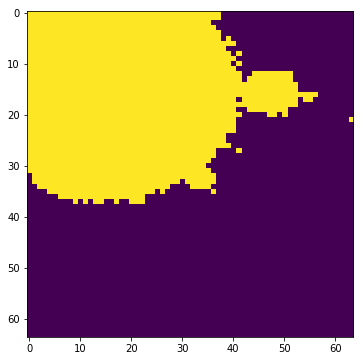

In [10]:
Xtile, Ytile = getXY( 1, 1, 2, 64  )
plt.figure(figsize=(6, 6)); 
plt.imshow( computeTile( Xtile, Ytile ) );

## Calcul de la pyramide

Le plus difficile est ensuite de parcourir la pyramide d'images et de lancer le calcul pour chaque image. Il est intéressant de faire un algorithme recursif, cohérent avec la description de l'image, et surtout permettant de detecter et de de ne pas calculer les images vides.

In [11]:
from PIL import Image

def saveImg(Z, loc):
    rescaled = (255.0 / Z.max() * (Z - Z.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save( loc )

In [12]:
# Configuration de l'image (Variables globales)
tile_size = 64
nbr_zoom = 9

filename = 'Mandelbrot%ipx%iL_files' % (tile_size, nbr_zoom)

print(filename)

print( "  -taille de l'image finale: %i px"%2**nbr_zoom )
print( "  -nombre de tuiles dans l'image finale: %i "% ((2**nbr_zoom)/tile_size)**2 )

Mandelbrot64px9L_files
  -taille de l'image finale: 512 px
  -nombre de tuiles dans l'image finale: 64 


In [13]:
import os

def computeSubTile( level=3, row=0, col=0 ):
    # Calcul :
    image_size = 2**level
    tile_size_loc = min( tile_size, image_size )
    nTiles = int( np.ceil( image_size/tile_size ))
    
    Xtile, Ytile = getXY( row, col, nTiles, tile_size_loc  )
    Z = computeTile( Xtile, Ytile )
    
    # Enregistre la tuile :
    dirname = './%s/%i' %(filename, level)
    if not os.path.exists(dirname):
        print( 'mkdir %s' %dirname )
        os.makedirs( dirname )
        
    imgname = '%s/%i_%i.png' %(dirname, col, row )
    saveImg(Z, imgname)    
    
    # Tuiles suivantes :
    if 2**(level+1) <= tile_size:
         computeSubTile( level=level+1, row=0, col=0 )
    elif level<nbr_zoom:
        # test quartier par quartier si l'image est non vide:
        for i in range(2):
            for j in range(2):
                nDemi = int( tile_size/2 )
                Zcrop = Z[ i*nDemi:(i+1)*nDemi, j*nDemi:(j+1)*nDemi  ]
                
                if np.max(Zcrop)-np.min(Zcrop)>.9 :
                    computeSubTile( level=level+1, row=2*row+i, col=2*col+j )

In [448]:
computeSubTile()

mkdir ./Mandelbrot64px9L_files/3
mkdir ./Mandelbrot64px9L_files/4
mkdir ./Mandelbrot64px9L_files/5
mkdir ./Mandelbrot64px9L_files/6
mkdir ./Mandelbrot64px9L_files/7
mkdir ./Mandelbrot64px9L_files/8
mkdir ./Mandelbrot64px9L_files/9


_Remarque:_ Le calcul avec des tuiles de 128px et 14 niveaux de zoom prends 2h15 sur mon ordi...

Le fichier _.DZI_  (xml) doit être ajouter à coté du répertoire d'images. Les informations à completer sont la taille des tuiles, et la taille de l'image au dernier niveau de zoom:

```
<?xml version="1.0" encoding="UTF-8"?>
<Image Format="png" Overlap="0" TileSize="128" xmlns="http://schemas.microsoft.com/deepzoom/2008">
    <Size Height="16384" Width="16384"/>
</Image>
```

Pour voir le résultat on peut utiliser le plugin javascript _OpenSeaDragon_ [ici](https://openseadragon.github.io/).